In [ ]:
 import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import string
import re

!pip install matplotlib
import matplotlib.pyplot as plt
nltk.download('punkt_tab')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  # Choose your desired model

from sklearn.svm import SVC
# Import the necessary class from the correct module
from sklearn.naive_bayes import MultinomialNB
!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
my_data=pd.read_excel("/content/Labeled_Urdu_Sentences.xlsx")

display(my_data.head(5))

,Label,Text
0,1,زندگی میں ہر دن ایک نیا موقع ہوتا ہے۔
1,1,محنت کبھی ضائع نہیں جاتی۔
2,1,دوستی زندگی کا سب سے خوبصورت رشتہ ہے۔
3,1,ہر رات کے بعد روشن صبح آتی ہے۔
4,1,خوشی دل کو سکون دیتی ہے۔


In [ ]:
my_data.columns = ['label', 'text']
my_data.dropna(inplace=True)
my_data['label'] = my_data['label'].astype(int)

In [ ]:
my_data.head(5)


,label,text
0,1,زندگی میں ہر دن ایک نیا موقع ہوتا ہے۔
1,1,محنت کبھی ضائع نہیں جاتی۔
2,1,دوستی زندگی کا سب سے خوبصورت رشتہ ہے۔
3,1,ہر رات کے بعد روشن صبح آتی ہے۔
4,1,خوشی دل کو سکون دیتی ہے۔


###EDA

In [ ]:
my_data.info()

# Check the column names to ensure proper reading
print(f"Columns: {my_data.columns}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   910 non-null    int64 
 1   text    910 non-null    object
dtypes: int64(1), object(1)
memory usage: 14.3+ KB
Columns: Index(['label', 'text'], dtype='object')


In [ ]:
# Step 7: Check for missing data
print("\nCheck for missing values:")
print(my_data.isnull().sum())

#Step 9: Get basic statistics on numerical columns (if applicable)
print("\nBasic statistics (numerical columns):")
print(my_data.describe(include="object"))
print(my_data.describe(include="number"))

# Step 10: Check unique values in sentiment column (assuming there's a sentiment column)
print("\nUnique lables values:")
print(my_data['label'].unique())

print(my_data["label"].value_counts())


Check for missing values:
label    0
text     0
dtype: int64

Basic statistics (numerical columns):
                                        text
count                                    910
unique                                    30
top     ہر کوئی اپنی جگہ پر صحیح ہو سکتا ہے۔
freq                                      33
            label
count  910.000000
mean     1.054945
std      0.817340
min      0.000000
25%      0.000000
50%      1.000000
75%      2.000000
max      2.000000

Unique lables values:
[1 0 2]
label
2    330
1    300
0    280
Name: count, dtype: int64


In [ ]:
'''# Check for duplicates in the 'text' column
print(f"Number of duplicate entries: {my_data.duplicated(subset=['text']).sum()}")
'''

'# Check for duplicates in the \'text\' column\nprint(f"Number of duplicate entries: {my_data.duplicated(subset=[\'text\']).sum()}")\n'

In [ ]:
'''# Remove duplicate entries
my_data = my_data.drop_duplicates(subset=['text'], keep='first').reset_index(drop=True)

# Verify removal
print(f"Number of duplicate entries after removal: {my_data.duplicated(subset=['text']).sum()}")
'''

'# Remove duplicate entries\nmy_data = my_data.drop_duplicates(subset=[\'text\'], keep=\'first\').reset_index(drop=True)\n\n# Verify removal\nprint(f"Number of duplicate entries after removal: {my_data.duplicated(subset=[\'text\']).sum()}")\n'

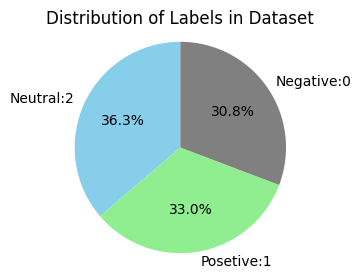

In [ ]:


# Data for labels distribution
labels_counts = [  330,  300, 280]
labels_names = ['Neutral:2', 'Posetive:1', 'Negative:0']

# Create a pie chart
plt.figure(figsize=(3, 3))
plt.pie(labels_counts, labels=labels_names, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen', 'gray'])
plt.title('Distribution of Labels in Dataset')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


### 2.Cleaning & Preprocessing

In [ ]:
# Define a function for tokenization
def tokenize(text):
    return nltk.word_tokenize(text)

# Apply tokenization to your DataFrame column
my_data['text'] = my_data['text'].apply(tokenize)
display(my_data['text'])

,text
0,"[زندگی, میں, ہر, دن, ایک, نیا, موقع, ہوتا, ہے۔]"
1,"[محنت, کبھی, ضائع, نہیں, جاتی۔]"
2,"[دوستی, زندگی, کا, سب, سے, خوبصورت, رشتہ, ہے۔]"
3,"[ہر, رات, کے, بعد, روشن, صبح, آتی, ہے۔]"
4,"[خوشی, دل, کو, سکون, دیتی, ہے۔]"
...,...
905,"[زندگی, میں, ہر, دن, مختلف, تجربے, لاتا, ہے۔]"
906,"[وقت, کے, ساتھ, چیزیں, بدل, جاتی, ہیں۔]"
907,"[چاندنی, رات, کا, منظر, دلکش, ہوتا, ہے۔]"
908,"[کچھ, سوالات, کے, جواب, نہیں, ملتے۔]"


In [ ]:
urdu_punctuation = '۔،؛؟'

# Combine English and Urdu punctuation
all_punctuations = string.punctuation + urdu_punctuation

# Remove punctuation function using re.sub
def remove_punctuations(text):
    # Join the list of tokens back into a single string
    text = ' '.join(text)
    return re.sub(r'[^\w\s]', '', text)

print(all_punctuations)

my_data["clean_text"] = my_data['text'].apply(remove_punctuations)
display(my_data.head(5))

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~۔،؛؟


,label,text,clean_text
0,1,"[زندگی, میں, ہر, دن, ایک, نیا, موقع, ہوتا, ہے۔]",زندگی میں ہر دن ایک نیا موقع ہوتا ہے
1,1,"[محنت, کبھی, ضائع, نہیں, جاتی۔]",محنت کبھی ضائع نہیں جاتی
2,1,"[دوستی, زندگی, کا, سب, سے, خوبصورت, رشتہ, ہے۔]",دوستی زندگی کا سب سے خوبصورت رشتہ ہے
3,1,"[ہر, رات, کے, بعد, روشن, صبح, آتی, ہے۔]",ہر رات کے بعد روشن صبح آتی ہے
4,1,"[خوشی, دل, کو, سکون, دیتی, ہے۔]",خوشی دل کو سکون دیتی ہے


In [ ]:

# Define Balochi stop words list
stop_words = [
    "آپ", "اس", "اسکا", "اسکے", "اسی", "اسے", "ان", "انکا", "انکی", "انکے",
    "انہیں", "اپنی", "اپنے", "اگر", "بھی", "تم", "تو", "تک", "تھا", "تھی",
    "تھے", "جب", "جس", "جو", "جہاں", "جیسے", "دیا", "دیں", "دے", "رہا",
    "رہی", "رہیں", "رہے", "سب", "سے", "صرف", "لیکن", "لیے", "مگر", "میں",
    "نہ", "نہی", "نے", "ور", "وہ", "وہاں", "پر", "کا", "کر", "کو", "کوئی",
    "کچھ", "کہ", "کی", "کیا", "کیونکہ", "کیوں", "کے", "گئی", "گیا", "ہر",
    "ہم", "ہو", "ہوتا", "ہوتے", "ہوگا", "ہوگی", "ہوں", "ہیں", "ہے", "یا",
    "یہ", "یہاں","آتی","دیتی","جاتی"
]


def remove_stop_words(text):
    from nltk.tokenize import word_tokenize
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    filtered_text = ' '.join(filtered_words)
    return filtered_text
# Apply stop words removal to your dataset
my_data["clean_text"] = my_data["clean_text"].apply(remove_stop_words)
# Display the cleaned data
display(my_data.head(5))


,label,text,clean_text
0,1,"[زندگی, میں, ہر, دن, ایک, نیا, موقع, ہوتا, ہے۔]",زندگی دن ایک نیا موقع
1,1,"[محنت, کبھی, ضائع, نہیں, جاتی۔]",محنت کبھی ضائع نہیں
2,1,"[دوستی, زندگی, کا, سب, سے, خوبصورت, رشتہ, ہے۔]",دوستی زندگی خوبصورت رشتہ
3,1,"[ہر, رات, کے, بعد, روشن, صبح, آتی, ہے۔]",رات بعد روشن صبح
4,1,"[خوشی, دل, کو, سکون, دیتی, ہے۔]",خوشی دل سکون


## Feature Engineering

In [ ]:
vectorizer_bow = CountVectorizer(encoding='utf-8', max_features=5000)
vectorizer_tfidf = TfidfVectorizer(encoding='utf-8', max_features=5000)

In [ ]:
#Example with n-grams in TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)  # Unigrams, bigrams, and trigrams
n_tfidf = vectorizer_tfidf.fit_transform(my_data["clean_text"])

In [ ]:
# Bag-of-Words feature extraction
X_bow = vectorizer_bow.fit_transform(my_data["clean_text"]).toarray()

# TF-IDF feature extraction

n_tfidf = vectorizer_tfidf.fit_transform(my_data["clean_text"]).toarray()

# Assign labels
y = my_data['label']

In [ ]:
# Ensure both X and y have the same number of samples before splitting
X_bow = X_bow[:len(y)]
n_tfidf = n_tfidf[:len(y)]
n_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(n_tfidf, y, test_size=0.2, random_state=42)

### BoW Models

In [ ]:
# Logistic Regression
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train_bow, y_train)
y_pred_log_reg = log_reg_model.predict(X_test_bow)

In [ ]:
# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_bow, y_train)
y_pred_nb = nb_model.predict(X_test_bow)

In [ ]:
# Support Vector Machine
svm_model = SVC()
svm_model.fit(X_train_bow, y_train)
y_pred_svm = svm_model.predict(X_test_bow)

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    print(f"{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

In [ ]:
#evaluate_model(y_test, y_pred_svm, "SVM")
evaluate_model(y_test,y_pred_log_reg, "logistic regression")
evaluate_model(y_test, y_pred_nb, "Naive Bayes")

logistic regression - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000
Naive Bayes - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


### TFIDF Models

In [ ]:
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train_tfidf, y_train_tfidf)
y_pred_log_reg = log_reg_model.predict(X_test_tfidf)

In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train_tfidf)
y_pred_nb = nb_model.predict(X_test_tfidf)

In [ ]:
svm_model = SVC()
svm_model.fit(X_train_tfidf, y_train_tfidf)
y_pred_svm = svm_model.predict(X_test_tfidf)

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    print(f"{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

In [ ]:
evaluate_model(y_test_tfidf, y_pred_svm, "SVM")
evaluate_model(y_test_tfidf,y_pred_log_reg, "logistic regression")
evaluate_model(y_test_tfidf, y_pred_nb, "Naive Bayes")

SVM - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000
logistic regression - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000
Naive Bayes - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


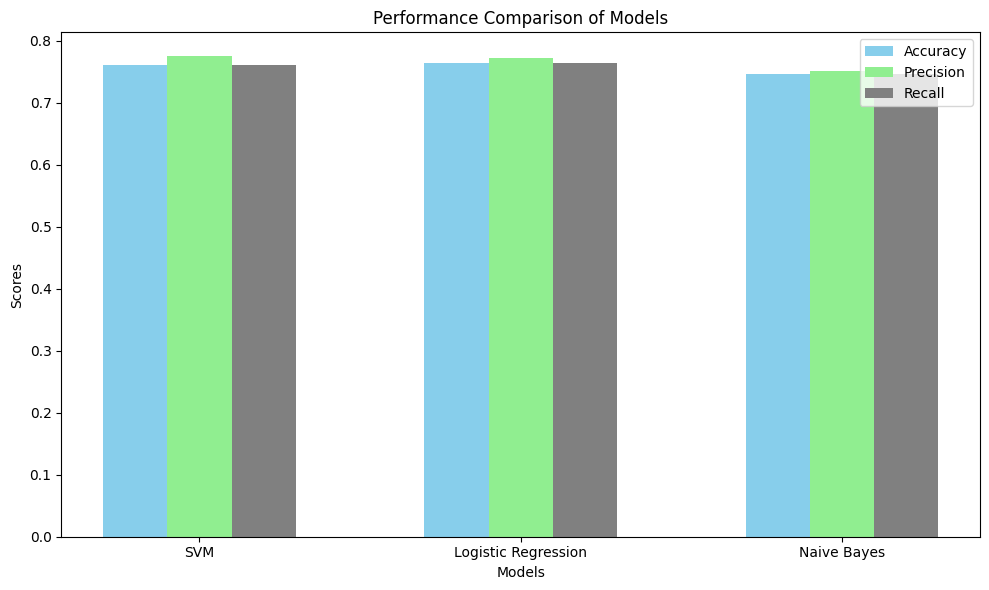

In [ ]:



# Data for plotting
models = ['SVM', 'Logistic Regression', 'Naive Bayes']
accuracy = [0.7614, 0.7651, 0.7466]
precision = [0.7751, 0.7731, 0.7514]
recall = [0.7614, 0.7651, 0.7466]

# Define bar positions
x = np.arange(len(models))
width = 0.20  # Width of bars

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(x - width, accuracy, width, label='Accuracy', color='skyblue')
plt.bar(x, precision, width, label='Precision', color='lightgreen')
plt.bar(x + width, recall, width, label='Recall', color='gray')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Performance Comparison of Models')
plt.xticks(x, models)
plt.legend()

# Show the chart
plt.tight_layout()
plt.show()


In [ ]:
#from sklearn.feature_extraction.text import TfidfVectorizer

def predict_sentiment(sentence, model, vectorizer):
    # Check if the input sentence is valid
    if not sentence.strip() or len(sentence.split()) < 3:  # Adjust word count threshold as needed
        return "Invalid input. Please enter a valid sentence in Balochi."

    # Transform the sentence using the same vectorizer used during training
    sentence_transformed = vectorizer.transform([sentence]).toarray() # Convert to dense array

    # Predict the sentiment
    prediction = model.predict(sentence_transformed)[0]

    # Map prediction result to sentiment label
    if prediction == 1:
        return "Positive"
    elif prediction == 0:
        return "Negative"
    else:
        return "Neutral"

# Assuming `model` is your trained model and `vectorizer_tfidf` is the fitted vectorizer
model = svm_model
vectorizer = vectorizer_tfidf

sentence = input("Enter a sentence to analyze: ")
result = predict_sentiment(sentence, model, vectorizer)
print("Sentiment:", result)

In [ ]:
def create_lstm_model(input_dim):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=64, input_length=50))
    model.add(LSTM(64))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adagrad', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
from tensorflow.keras.layers import LSTM
lstm_model = create_lstm_model(input_dim=5000)
lstm_model.fit(X_train_tfidf, y_train, epochs=20, batch_size=32, validation_split=0.2)
lstm_eval = lstm_model.evaluate(X_test_tfidf, y_test)
print(f"LSTM Model - Accuracy: {lstm_eval[1]:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 37s 146ms/step - accuracy: 0.3485 - loss: 1.0980 - val_accuracy: 0.3676 - val_loss: 1.0946
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 33s 151ms/step - accuracy: 0.3833 - loss: 1.0932 - val_accuracy: 0.3676 - val_loss: 1.0933
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 40s 148ms/step - accuracy: 0.3822 - loss: 1.0922 - val_accuracy: 0.3676 - val_loss: 1.0929
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 40s 145ms/step - accuracy: 0.3693 - loss: 1.0931 - val_accuracy: 0.3676 - val_loss: 1.0927
Epoch 5/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - accuracy: 0.3856 - loss: 1.0903 - val_accuracy: 0.3676 - val_loss: 1.0927
Epoch 6/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 42s 152ms/step - accuracy: 0.3781 - loss: 1.0915 - val_accuracy: 0.3676 - val_loss: 1.0927
Epoch 7/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 42s 158ms/step - accuracy: 0.3790 - loss: 1.0918 - val_accuracy: 0.3676 - val_loss: 1.0927
Epoch 8/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 38s 145ms/step - accuracy: 0.3882 - loss: 1